In [4]:
#---Installing required libraries--#
import sys
sys.executable

'C:\\ProgramData\\anaconda3\\python.exe'

In [5]:
!C:\\ProgramData\\anaconda3\\python.exe -m pip install yfinance

     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ------------------------------- ------ 786.4/948.2 kB 3.4 MB/s eta 0:00:01
     -------------------------------------- 948.2/948.2 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139012 sha256=f46df4176eac18a7850c2bc3f023e67f99474f18c365b3dada381ffe2f8fa736
  Stored in directory: c:\users\jayes\appdata\local\pip\cache\wheels\8f\65\34\456800445efeafb05164fe95285c70e81ba1d96bae30f43917
Successfully built peewee


In [7]:
import pandas as pd
import yfinance as yf
import datetime
import seaborn
import numpy as np
from statsmodels.tsa.stattools import coint,adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [8]:
start = datetime.datetime(2015, 6, 1)
end = datetime.datetime(2023, 6, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers ,start ,end)['Close']
df.dropna(inplace=True)
#most recent data
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2023-05-24,365.760010,313.850006
2023-05-25,392.059998,325.920013
2023-05-26,415.390015,332.890015
2023-05-30,417.209991,331.209991
2023-05-31,417.790009,328.390015


In [9]:
corr_matrix = df.corr()
corr_matrix

Ticker,ADBE,MSFT
Ticker,,
ADBE,1.00000,0.92448
MSFT,0.92448,1.00000


<Axes: xlabel='Ticker', ylabel='Ticker'>

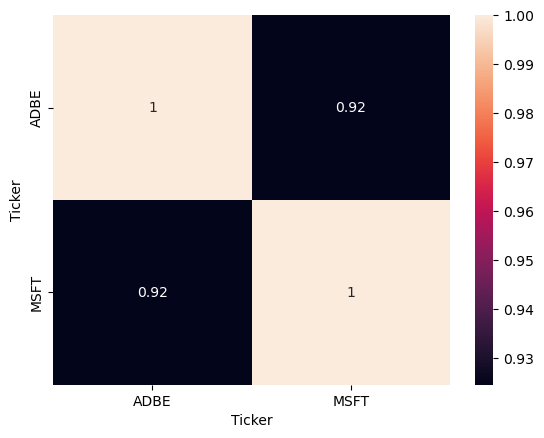

In [10]:
# Let's heatmap this matrix so that we can have a better sense of what is going on
import seaborn as sn
from matplotlib.pyplot import figure
sn.heatmap(corr_matrix, annot = True)

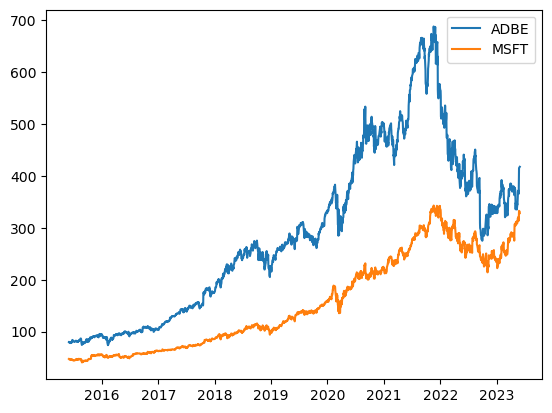

In [11]:
import matplotlib.pyplot as plt
ADBE = df['ADBE']
MSFT = df['MSFT'] 
# HOWEVER, let's check out the relationship between the stocks...
plt.plot(ADBE, label = "ADBE")
plt.plot(MSFT, label = "MSFT")
plt.legend()

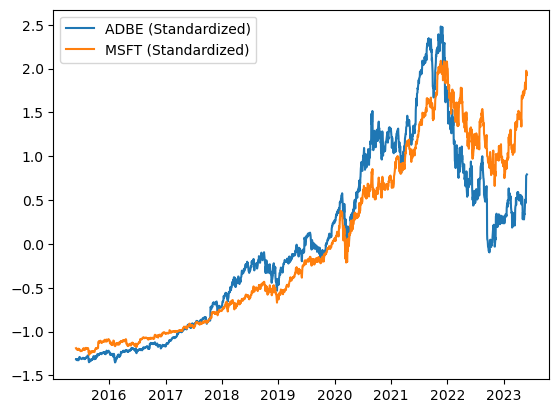

In [12]:
ADBE_std = (ADBE - ADBE.mean()) / ADBE.std()
MSFT_std = (MSFT - MSFT.mean()) / MSFT.std()

plt.plot(ADBE_std, label="ADBE (Standardized)")
plt.plot(MSFT_std, label="MSFT (Standardized)")
plt.legend()
plt.show()

In [13]:
# not pao
S1 = ADBE_std
S2 = MSFT_std

score, pvalue, _ = coint(S1,S2)
print(pvalue)


0.928621300115226


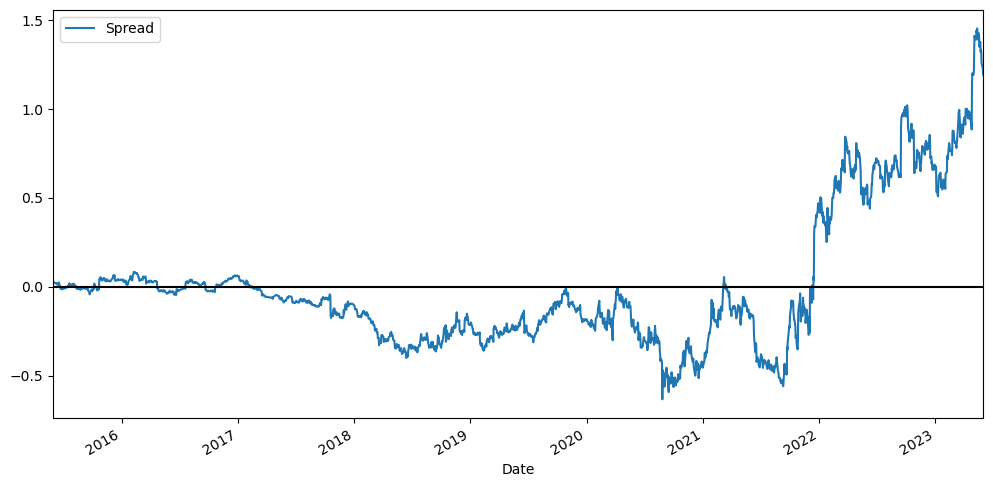

In [14]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2015-6-1', '2023-6-1')
plt.legend(['Spread']);

In [15]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [16]:
stationarity_test(S1)
stationarity_test(S2)

p-value = 0.6419500808592975 The series ADBE is likely non-stationary.
p-value = 0.9655487965019599 The series MSFT is likely non-stationary.


In [17]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
# First differencing
S1 = S1.diff().dropna()
S2 = S2.diff().dropna()

stationarity_test(S1)
stationarity_test(S2)

coint_t, p_value, critical_values = coint(S1, S2)
print("Cointegration p-value:", p_value)

p-value = 1.615651097862256e-26 The series ADBE is likely stationary.
p-value = 2.1080764198153553e-27 The series MSFT is likely stationary.
Cointegration p-value: 0.0


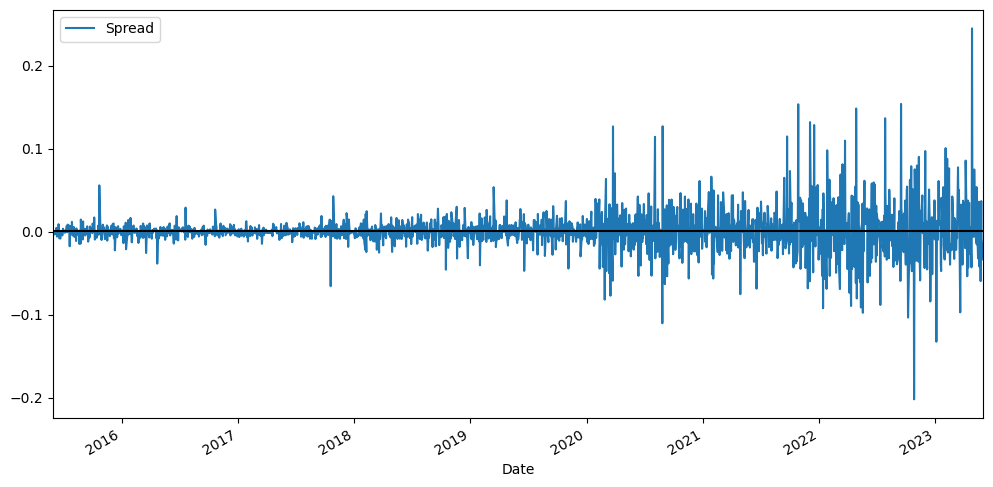

In [18]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2015-6-1', '2023-6-1')
plt.legend(['Spread']);

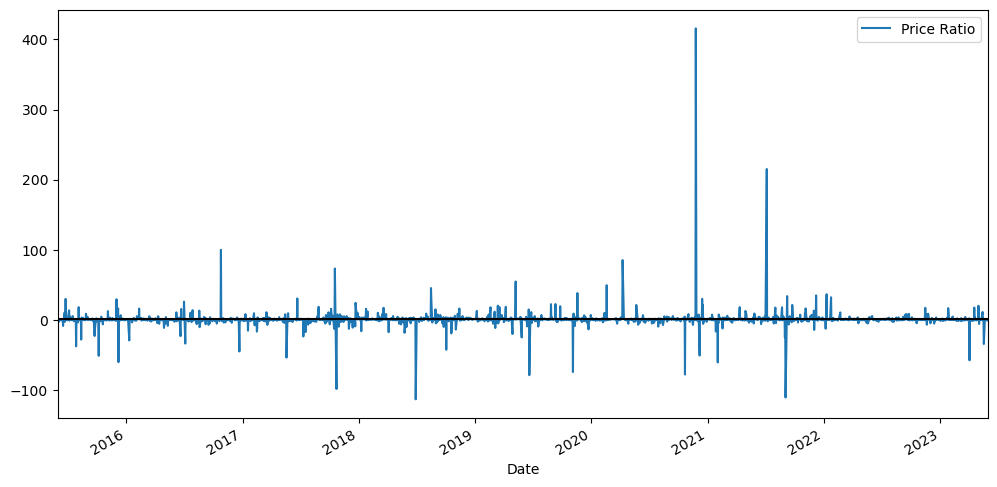

In [22]:
ratio = S1 / S2.replace(0, np.nan)  # Replace 0 with NaN to avoid division errors
ratio = ratio.dropna()  # Remove NaN values

ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2015-6-1', '2023-6-1')
plt.legend(['Price Ratio'])
plt.show()


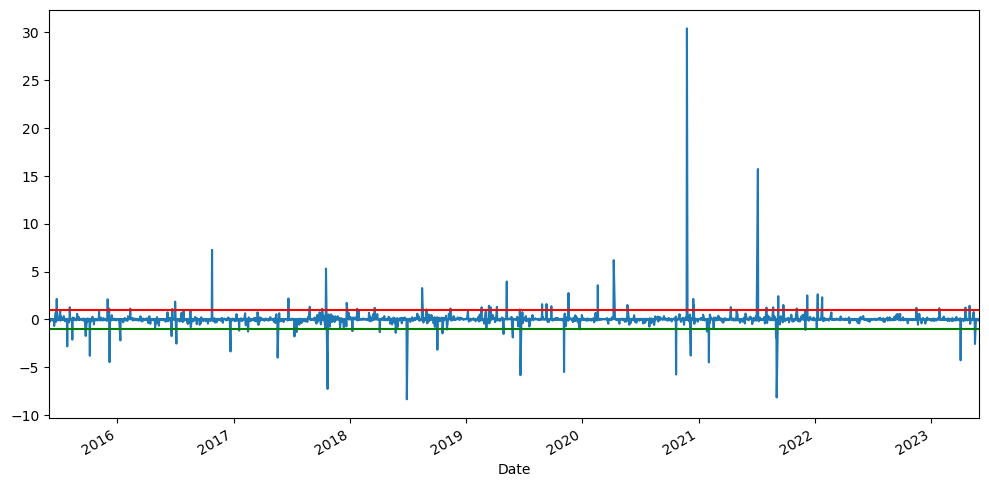

In [23]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2015-6-1', '2023-6-1')
plt.show()

1410.5


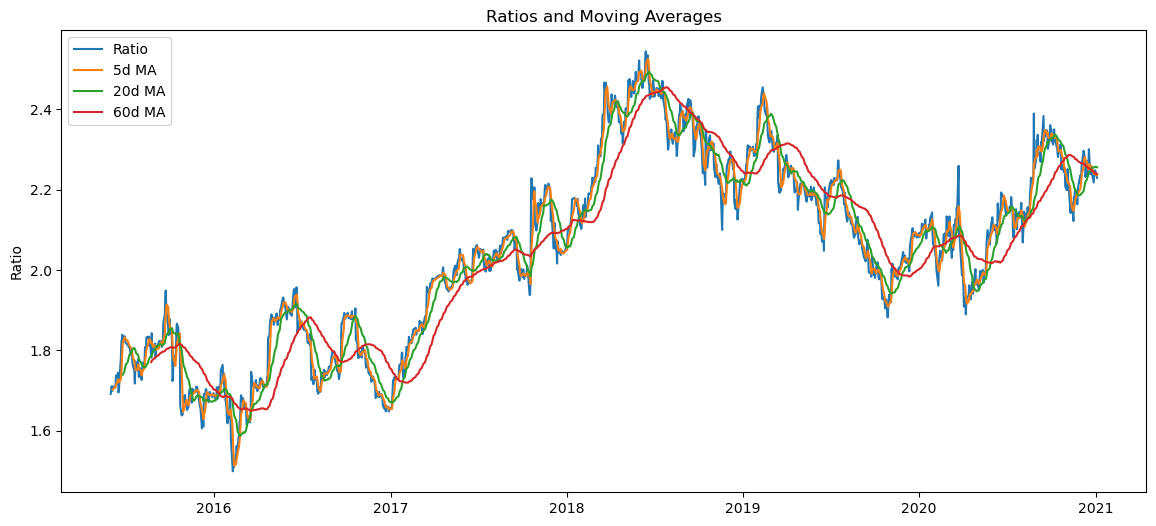

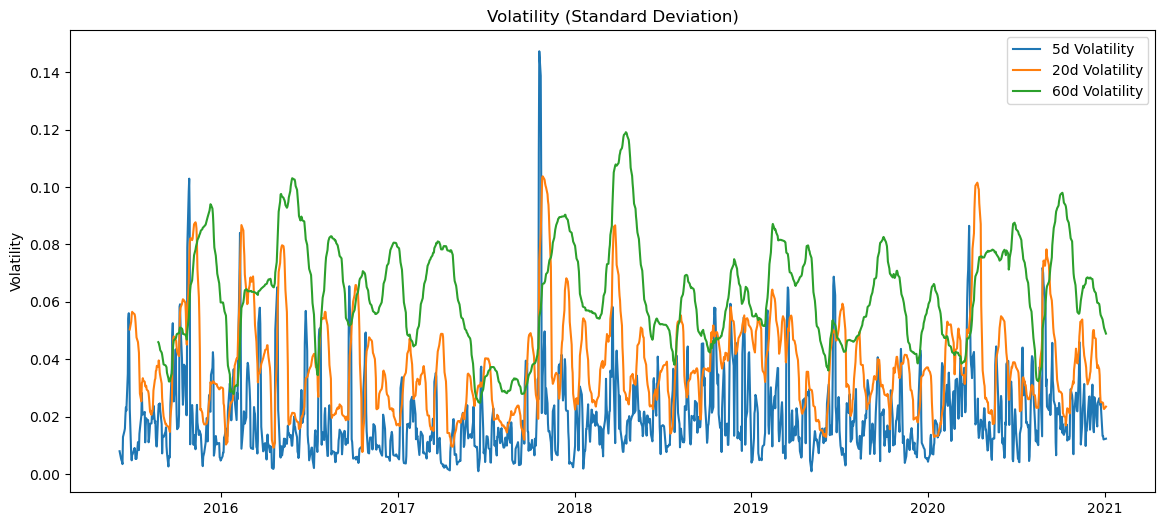

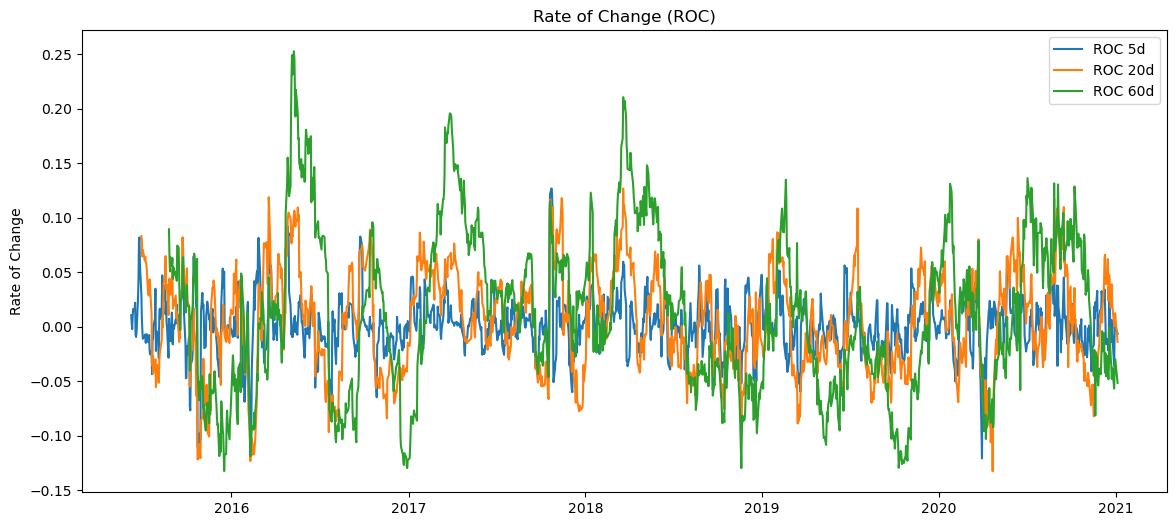

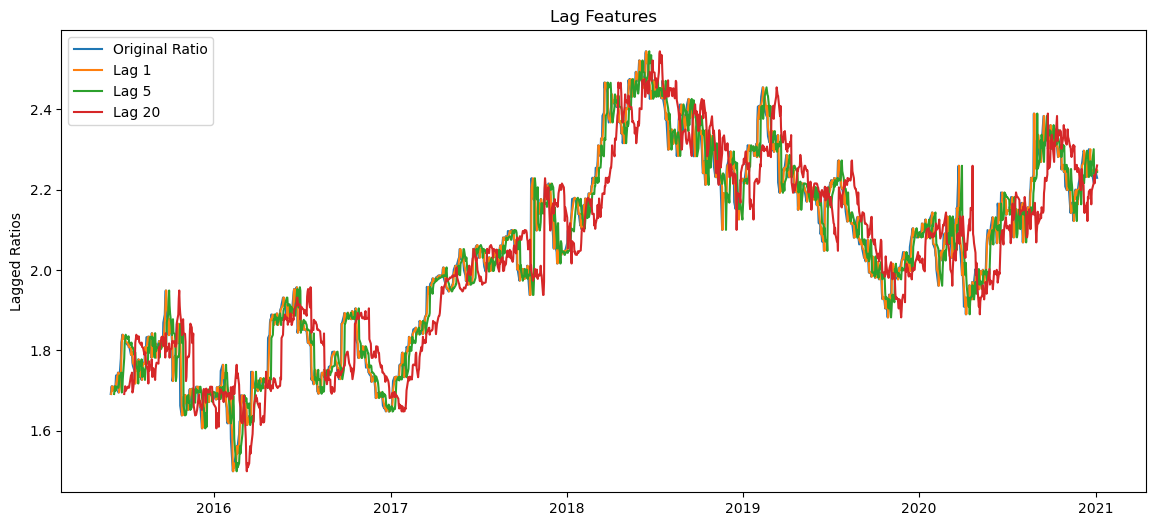

In [75]:
# ratios = df['ADBE'] / df['MSFT']
# print(len(ratios) * .70 )

# train = ratios[:1410]
# test = ratios[1410:]

# ratios_mavg5 = train.rolling(window=5, center=False).mean()
# ratios_mavg60 = train.rolling(window=60, center=False).mean()
# std_60 = train.rolling(window=60, center=False).std()
# zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
# plt.figure(figsize=(12, 6))
# plt.plot(train.index, train.values)
# plt.plot(ratios_mavg5.index, ratios_mavg5.values)
# plt.plot(ratios_mavg60.index, ratios_mavg60.values)
# plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

# plt.ylabel('Ratio')
# plt.show()


import pandas as pd
import matplotlib.pyplot as plt

# Ratios calculation
ratios = df['ADBE'] / df['MSFT']
print(len(ratios) * .70)

# Train-test split
train = ratios[:1410]
test = ratios[1410:]

# Moving Averages
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg20 = train.rolling(window=20, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()

# Standard Deviation (Volatility)
std_5 = train.rolling(window=5, center=False).std()
std_20 = train.rolling(window=20, center=False).std()
std_60 = train.rolling(window=60, center=False).std()

# Rate of Change (ROC)
roc_5 = train.pct_change(periods=5)
roc_20 = train.pct_change(periods=20)
roc_60 = train.pct_change(periods=60)

# Lag Features
train_lag_1 = train.shift(1)  # 1-day lag
train_lag_5 = train.shift(5)  # 5-day lag
train_lag_20 = train.shift(20)  # 20-day lag

# Z-Score for 60-day and 5-day moving average
zscore_60_5 = (ratios_mavg5 - ratios_mavg60) / std_60


# Drop rows with NaNs
train = train.dropna()
ratios_mavg5 = ratios_mavg5.dropna()
ratios_mavg20 = ratios_mavg20.dropna()
ratios_mavg60 = ratios_mavg60.dropna()
std_5 = std_5.dropna()
std_20 = std_20.dropna()
std_60 = std_60.dropna()
roc_5 = roc_5.dropna()
roc_20 = roc_20.dropna()
roc_60 = roc_60.dropna()
train_lag_1 = train_lag_1.dropna()
train_lag_5 = train_lag_5.dropna()
train_lag_20 = train_lag_20.dropna()


# Plotting Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Ratio')
plt.plot(ratios_mavg5.index, ratios_mavg5.values, label='5d MA')
plt.plot(ratios_mavg20.index, ratios_mavg20.values, label='20d MA')
plt.plot(ratios_mavg60.index, ratios_mavg60.values, label='60d MA')
plt.legend()
plt.title('Ratios and Moving Averages')
plt.ylabel('Ratio')
plt.show()

# Plotting Volatility (Standard Deviation)
plt.figure(figsize=(14, 6))
plt.plot(std_5.index, std_5.values, label='5d Volatility')
plt.plot(std_20.index, std_20.values, label='20d Volatility')
plt.plot(std_60.index, std_60.values, label='60d Volatility')
plt.legend()
plt.title('Volatility (Standard Deviation)')
plt.ylabel('Volatility')
plt.show()

# Plotting Rate of Change (ROC)
plt.figure(figsize=(14, 6))
plt.plot(roc_5.index, roc_5.values, label='ROC 5d')
plt.plot(roc_20.index, roc_20.values, label='ROC 20d')
plt.plot(roc_60.index, roc_60.values, label='ROC 60d')
plt.legend()
plt.title('Rate of Change (ROC)')
plt.ylabel('Rate of Change')
plt.show()

# Plotting Lag Features
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, label='Original Ratio')
plt.plot(train_lag_1.index, train_lag_1.values, label='Lag 1')
plt.plot(train_lag_5.index, train_lag_5.values, label='Lag 5')
plt.plot(train_lag_20.index, train_lag_20.values, label='Lag 20')
plt.legend()
plt.title('Lag Features')
plt.ylabel('Lagged Ratios')
plt.show()


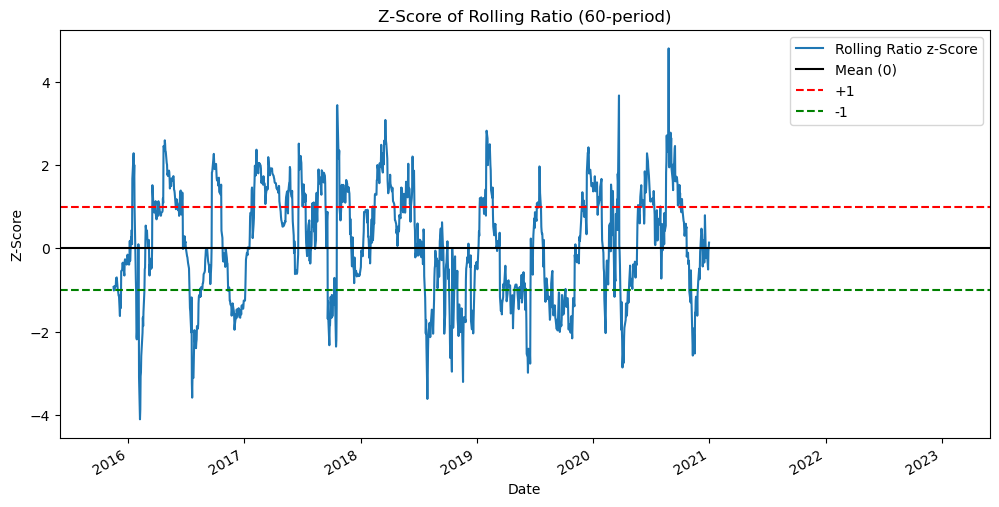

In [115]:
import matplotlib.pyplot as plt

# Assuming zscore_60_5 is already computed and contains the Z-score of the rolling ratio

# Create a plot for the zscore_60_5
plt.figure(figsize=(12, 6))

# Plot zscore_60_5
zscore_60_5.plot(label='Rolling Ratio z-Score')

# Set limits for x-axis (date range)
plt.xlim('2015-06-01', '2023-06-01')

# Add horizontal lines for the mean (0), +1, and -1 levels
plt.axhline(0, color='black', label='Mean (0)')
plt.axhline(1.0, color='red', linestyle='--', label='+1')
plt.axhline(-1.0, color='green', linestyle='--', label='-1')

# Add legend
plt.legend()

# Show the plot
plt.title('Z-Score of Rolling Ratio (60-period)')
plt.xlabel('Date')
plt.ylabel('Z-Score')

plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 0.0006
R^2 Score: 0.9774


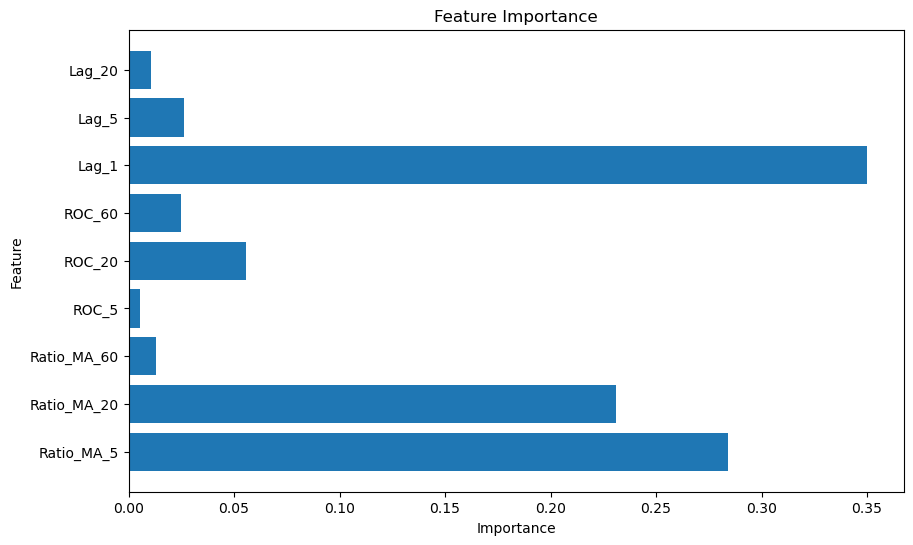

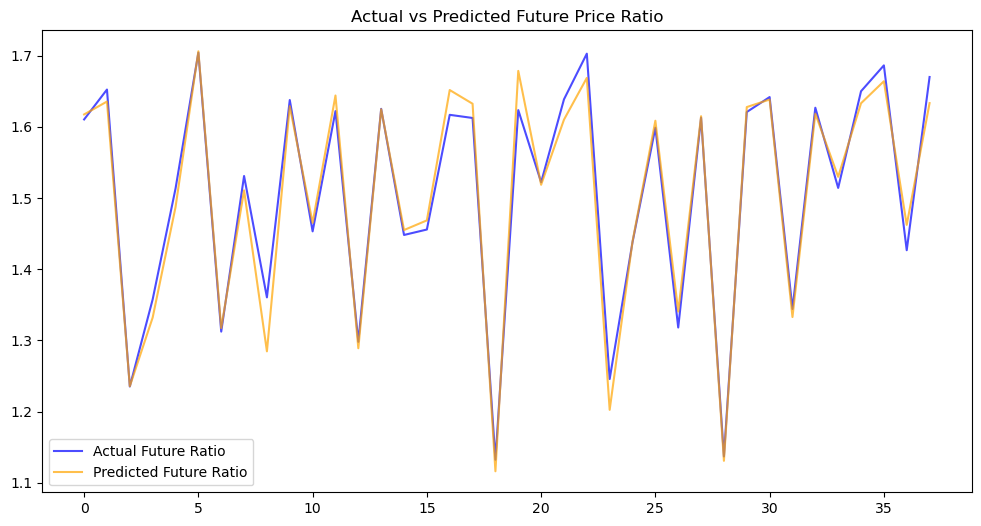

In [125]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset (assuming you have 'ADBE' and 'MSFT' prices)
# Replace with the dataset loading logic if needed
data = pd.DataFrame()
data['ADBE'] = yf.download('ADBE', start='2023-01-01', end='2023-12-31')['Adj Close']
data['MSFT'] = yf.download('MSFT', start='2023-01-01', end='2023-12-31')['Adj Close']

# Calculate the Price Ratio
data['Price_Ratio'] = data['ADBE'] / data['MSFT']

# Feature Engineering
data['Ratio_MA_5'] = data['Price_Ratio'].rolling(window=5).mean()
data['Ratio_MA_20'] = data['Price_Ratio'].rolling(window=20).mean()
data['Ratio_MA_60'] = data['Price_Ratio'].rolling(window=60).mean()
data['ROC_5'] = data['Price_Ratio'].pct_change(periods=5)
data['ROC_20'] = data['Price_Ratio'].pct_change(periods=20)
data['ROC_60'] = data['Price_Ratio'].pct_change(periods=60)
data['Lag_1'] = data['Price_Ratio'].shift(1)
data['Lag_5'] = data['Price_Ratio'].shift(5)
data['Lag_20'] = data['Price_Ratio'].shift(20)

# Target variable: Future Ratio (shifted -1 day)
data['Future_Ratio'] = data['Price_Ratio'].shift(-1)

# Drop rows with NaN values
data = data.dropna()

# Prepare features (X) and target (y)
X = data[['Ratio_MA_5', 'Ratio_MA_20', 'Ratio_MA_60', 'ROC_5', 'ROC_20', 
          'ROC_60', 'Lag_1', 'Lag_5', 'Lag_20']]
y = data['Future_Ratio']

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict future ratios
y_pred = model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot Actual vs Predicted Ratios
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual Future Ratio', color='blue', alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label='Predicted Future Ratio', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Future Price Ratio')
plt.legend()
plt.show()


Hold    25
Buy      8
Sell     5
Name: count, dtype: int64


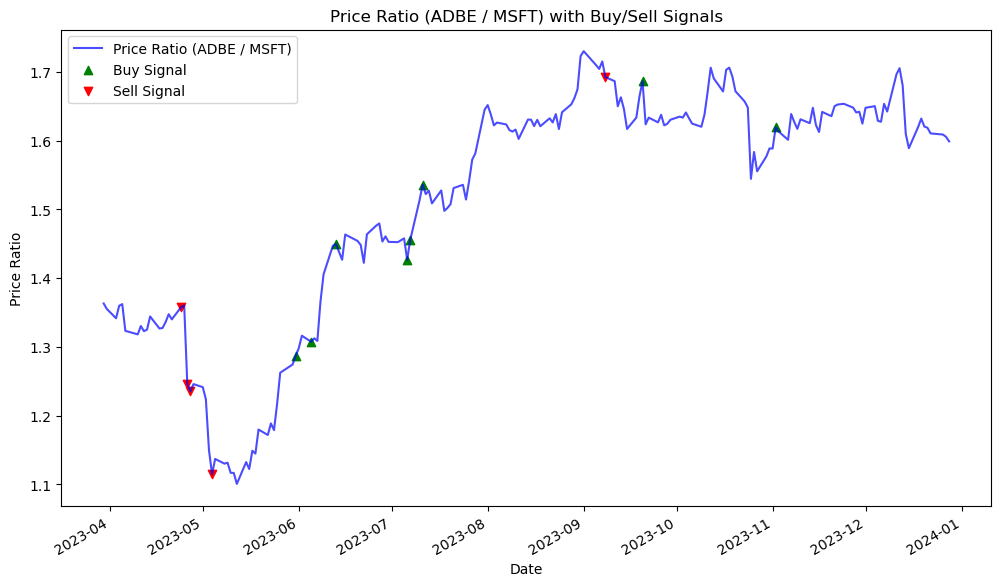

In [131]:
# Generate Buy/Sell signals based on the predicted ratio and current ratio
threshold = 0.01  # You can adjust the threshold to control when to generate signals

# Assuming 'y_pred' are the predicted future ratios for the test set
# Get the current ratios for the test set
current_ratio = X_test['Ratio_MA_5']  # Use the most recent ratio as the current ratio (you can select another feature)

# Generate signals
signals = pd.Series('Hold', index=X_test.index)  # Default signal is 'Hold'

# Buy signal: If predicted future ratio is significantly higher than the current ratio
signals[y_pred > current_ratio * (1 + threshold)] = 'Buy'

# Sell signal: If predicted future ratio is significantly lower than the current ratio
signals[y_pred < current_ratio * (1 - threshold)] = 'Sell'

# Show the generated signals
print(signals.value_counts())

# Plotting the actual price ratio and signals
plt.figure(figsize=(12, 7))

# Plot the Price Ratio of ADBE/MSFT
data['Price_Ratio'].plot(color='b', label='Price Ratio (ADBE / MSFT)', alpha=0.7)

# Plot Buy and Sell signals
buy_signals = signals[signals == 'Buy']  # Buy signals
sell_signals = signals[signals == 'Sell']  # Sell signals

# Plot Buy and Sell markers on the Price Ratio
plt.scatter(buy_signals.index, data['Price_Ratio'][buy_signals.index], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, data['Price_Ratio'][sell_signals.index], marker='v', color='r', label='Sell Signal', alpha=1)

# Customize the plot
plt.title('Price Ratio (ADBE / MSFT) with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()

# Show the plot
plt.show()



C:\Users\jayes\AppData\Local\Temp\ipykernel_20916\2170807088.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  signals[buy_signal] = 'Buy'


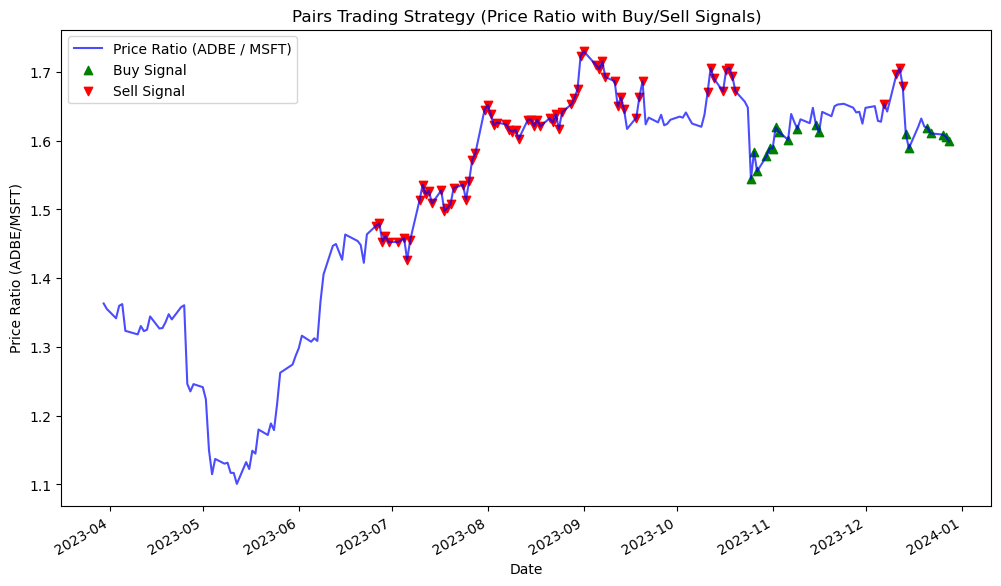

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'data' DataFrame with 'Price_Ratio' calculated
# Let's also assume zscore_60_5 is calculated already

# Example:
# zscore_60_5 = (data['Price_Ratio'] - data['Price_Ratio'].rolling(window=60).mean()) / data['Price_Ratio'].rolling(window=60).std()

# You may need to calculate z-score like this if it's not already defined:
data['zscore_60_5'] = (data['Price_Ratio'] - data['Price_Ratio'].rolling(window=60).mean()) / data['Price_Ratio'].rolling(window=60).std()

# Create Buy and Sell signals based on z-score
buy_signal = (data['zscore_60_5'] < -.5)  # Buy when z-score is less than -1
sell_signal = (data['zscore_60_5'] > .5)  # Sell when z-score is greater than 1

# Initialize signals DataFrame to store buy/sell values
signals = pd.Series(index=data.index)

# Assign 'Buy' and 'Sell' to the signals
signals[buy_signal] = 'Buy'
signals[sell_signal] = 'Sell'

# Plotting the Price Ratio and the Pairs Trading Strategy
plt.figure(figsize=(12, 7))

# Plot the Price Ratio of ADBE/MSFT
data['Price_Ratio'].plot(color='b', label='Price Ratio (ADBE / MSFT)', alpha=0.7)

# Plot Buy and Sell markers on the Price Ratio
buy_signals = signals[signals == 'Buy']  # Buy signals
sell_signals = signals[signals == 'Sell']  # Sell signals

# Plot Buy and Sell markers
plt.scatter(buy_signals.index, data['Price_Ratio'][buy_signals.index], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, data['Price_Ratio'][sell_signals.index], marker='v', color='r', label='Sell Signal', alpha=1)

# Customize the plot
plt.title('Pairs Trading Strategy (Price Ratio with Buy/Sell Signals)')
plt.xlabel('Date')
plt.ylabel('Price Ratio (ADBE/MSFT)')
plt.legend()

# Show the plot
plt.show()


C:\Users\jayes\AppData\Local\Temp\ipykernel_20916\1480784734.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  signals[buy_signal] = 'Buy'


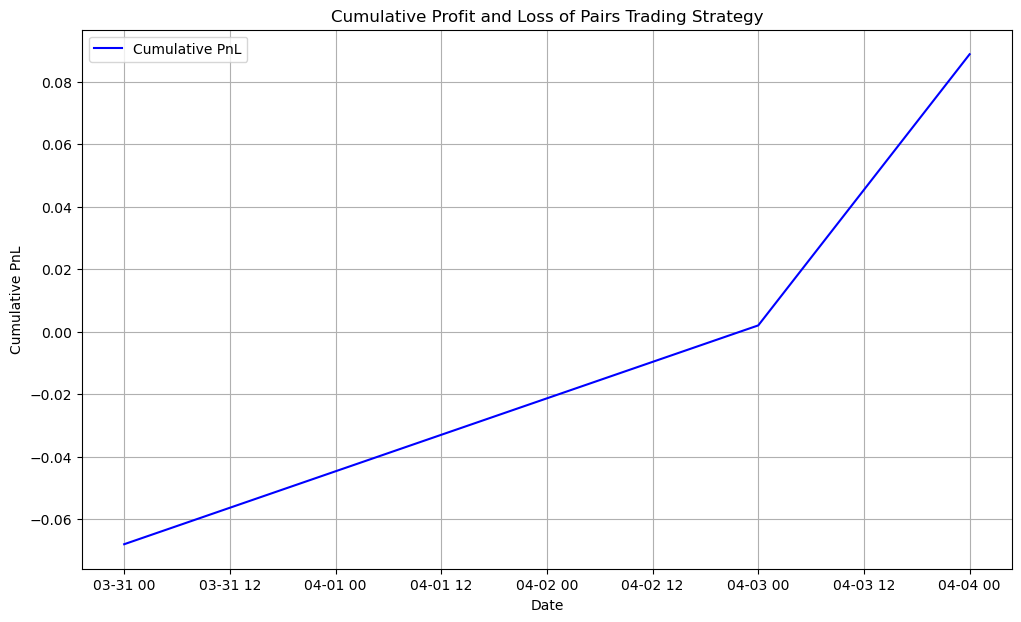

Total PnL: 0.09


C:\Users\jayes\AppData\Local\Temp\ipykernel_20916\1480784734.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Total PnL: {cumulative_pnl[-1]:.2f}")


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have 'data' DataFrame with Price_Ratio and zscore_60_5

# Adjust the thresholds to generate more signals
buy_signal = (data['zscore_60_5'] < -0.5)  # Buy when z-score is less than -0.5
sell_signal = (data['zscore_60_5'] > 0.5)  # Sell when z-score is greater than 0.5

# Initialize signals DataFrame to store buy/sell values (using NaN initially)
signals = pd.Series(np.nan, index=data.index)

# Assign Buy and Sell signals
signals[buy_signal] = 'Buy'
signals[sell_signal] = 'Sell'

# Simulate the strategy
pnl = []  # List to store PnL for each trade
position = None  # Current position (None, 'long' or 'short')
buy_price = None  # Price at which we bought the position
sell_price = None  # Price at which we sold the position

# Iterate through the signals to simulate the trades
for i in range(1, len(data)):
    if signals.iloc[i] == 'Buy' and position is None:
        # Enter a long position (buy ADBE, sell MSFT)
        position = 'long'
        buy_price = data['Price_Ratio'].iloc[i]
    elif signals.iloc[i] == 'Sell' and position == 'long':
        # Close the long position (sell ADBE, buy MSFT)
        sell_price = data['Price_Ratio'].iloc[i]
        pnl.append(sell_price - buy_price)  # Profit is the change in the price ratio
        position = None  # Reset the position
    elif signals.iloc[i] == 'Sell' and position is None:
        # Enter a short position (sell ADBE, buy MSFT)
        position = 'short'
        buy_price = data['Price_Ratio'].iloc[i]
    elif signals.iloc[i] == 'Buy' and position == 'short':
        # Close the short position (buy ADBE, sell MSFT)
        sell_price = data['Price_Ratio'].iloc[i]
        pnl.append(buy_price - sell_price)  # Profit is the reverse of the price ratio change
        position = None  # Reset the position

# Convert PnL to a DataFrame
pnl = pd.Series(pnl, index=data.index[1:len(pnl)+1])  # Align PnL to dates

# Calculate the cumulative PnL
cumulative_pnl = pnl.cumsum()

# Plotting the cumulative PnL over time
plt.figure(figsize=(12, 7))
plt.plot(cumulative_pnl, label='Cumulative PnL', color='b')
plt.title('Cumulative Profit and Loss of Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

# Display the total profit or loss
print(f"Total PnL: {cumulative_pnl[-1]:.2f}")
